In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

import tensorflow as tf

In [2]:
# Load the preprocessed data
train_path = "../dataset/preprocessed/netflix_train.csv"
val_path = "../dataset/preprocessed/netflix_val.csv"
test_path = "../dataset/preprocessed/netflix_test.csv"

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Combine title and description for each sample
train_text = train_data['title'] + ' ' + train_data['description']
val_text = val_data['title'] + ' ' + val_data['description']
test_text = test_data['title'] + ' ' + test_data['description']

# Tokenize the text data
max_words = 5000  # Adjust based on your dataset
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_text)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_text)
val_sequences = tokenizer.texts_to_sequences(val_text)
test_sequences = tokenizer.texts_to_sequences(test_text)

# Pad sequences for consistent input length
max_len = 300  # Adjust based on your dataset
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [3]:
class Classifier(tf.keras.Model):
    def __init__(self, embedding_size, num_embeddings, num_channels, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0, emb_freeze=True):
        super(Classifier, self).__init__()

        if pretrained_embeddings is None:
            self.emb = Embedding(input_dim=num_embeddings, output_dim=embedding_size,
                                 input_length=max_len, trainable=True,
                                 mask_zero=True)        
        else:
            self.emb = Embedding(input_dim=num_embeddings, output_dim=embedding_size,
                                 input_length=max_len, weights=[pretrained_embeddings],
                                 trainable=not emb_freeze, mask_zero=True)

        self.conv1d_4gram = Conv1D(filters=num_channels, kernel_size=4, activation=relu)
        self.conv1d_3gram = Conv1D(filters=num_channels, kernel_size=3, activation=relu)
        self.conv1d_2gram = Conv1D(filters=num_channels, kernel_size=2, activation=relu)

        self.dropout_p = dropout_p
        self.global_max_pooling = GlobalMaxPooling1D()
        self.fc1 = Dense(hidden_dim, activation=relu)
        self.dropout = Dropout(dropout_p)
        self.fc2 = Dense(num_classes, activation=softmax)

    def call(self, x, apply_softmax=False):
        x_embedded = self.emb(x)

        features_4gram = self.global_max_pooling(self.conv1d_4gram(x_embedded))
        features_3gram = self.global_max_pooling(self.conv1d_3gram(x_embedded))
        features_2gram = self.global_max_pooling(self.conv1d_2gram(x_embedded))

        features = tf.concat([features_4gram, features_3gram, features_2gram], axis=1)

        features = self.dropout(features)

        intermediate_vector = self.dropout(self.fc1(features))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = softmax(prediction_vector)

        return prediction_vector

# 设置一些参数
embedding_size = 100
num_embeddings = 5000 # 这里根据你的数据集大小进行设置
num_channels = 100
hidden_dim = 100
# learning_rate=0.001
num_classes = 14  # 根据你的分类数量进行设置
dropout_p = 0.1
padding_idx = 0
emb_freeze = True

# 实例化模型
model = Classifier(embedding_size, num_embeddings, num_channels, 
                       hidden_dim, num_classes, dropout_p, 
                       padding_idx=padding_idx, emb_freeze=emb_freeze)

# 编译模型
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])

# 打印模型结构
model.build(input_shape=(None, max_len))
model.summary()



Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  500000    
                                                                 
 conv1d (Conv1D)             multiple                  40100     
                                                                 
 conv1d_1 (Conv1D)           multiple                  30100     
                                                                 
 conv1d_2 (Conv1D)           multiple                  20100     
                                                                 
 global_max_pooling1d (Glob  multiple                  0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               multiple                  30100     
                                                      

In [4]:
le = LabelEncoder()
train_labels = le.fit_transform(train_data['rating'])
val_labels = le.transform(val_data['rating'])
test_labels = le.transform(test_data['rating'])

print("训练数据集样本description数:", len(train_padded))
print("训练标签集数:", len(train_labels))
print("训练标签集:", train_labels)

训练数据集样本description数: 6160
训练标签集数: 6160
训练标签集: [ 8 11  8 ...  8  6 10]


d:\python\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\python\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\python\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\python\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\python\lib\site-packages\sklearn\utils\va

In [5]:
embedding_dim = 100
glove_path = '../dataset/glove/glove.6B.100d.txt'

# 解析 GloVe 文件，建立词向量字典
embeddings_index = {}
with open(glove_path, encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [6]:
# 创建词嵌入矩阵
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [7]:
history = model.fit(train_padded, train_labels,
                    epochs=15,
                    batch_size=64,
                    validation_data=(val_padded, val_labels))

Epoch 1/15

97/97 [==============================] - 10s 88ms/step - loss: 1.9313 - sparse_categorical_accuracy: 0.3615 - val_loss: 1.8248 - val_sparse_categorical_accuracy: 0.3455
Epoch 2/15
97/97 [==============================] - 8s 83ms/step - loss: 1.6960 - sparse_categorical_accuracy: 0.4067 - val_loss: 1.7390 - val_sparse_categorical_accuracy: 0.3561
Epoch 3/15
97/97 [==============================] - 9s 89ms/step - loss: 1.3927 - sparse_categorical_accuracy: 0.5222 - val_loss: 1.6785 - val_sparse_categorical_accuracy: 0.3818
Epoch 4/15
97/97 [==============================] - 8s 85ms/step - loss: 0.9355 - sparse_categorical_accuracy: 0.7005 - val_loss: 1.8451 - val_sparse_categorical_accuracy: 0.3826
Epoch 5/15
97/97 [==============================] - 8s 84ms/step - loss: 0.5294 - sparse_categorical_accuracy: 0.8503 - val_loss: 2.1320 - val_sparse_categorical_accuracy: 0.3674
Epoch 6/15
97/97 [==============================] - 8s 84ms/step - loss: 0.2758 - sparse_categorical_ac

In [8]:
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

42/42 [==============================] - 0s 11ms/step - loss: 4.3155 - sparse_categorical_accuracy: 0.3538
Test Loss: 4.315547466278076, Test Accuracy: 0.3537878692150116


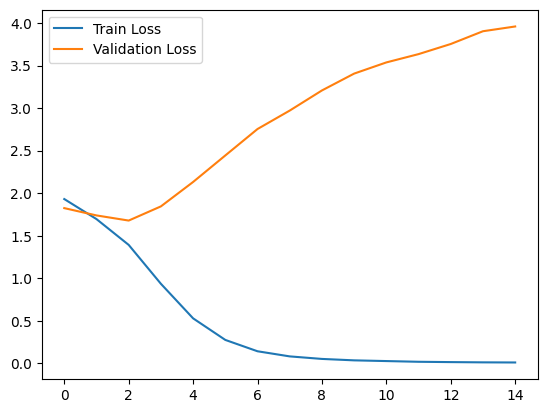

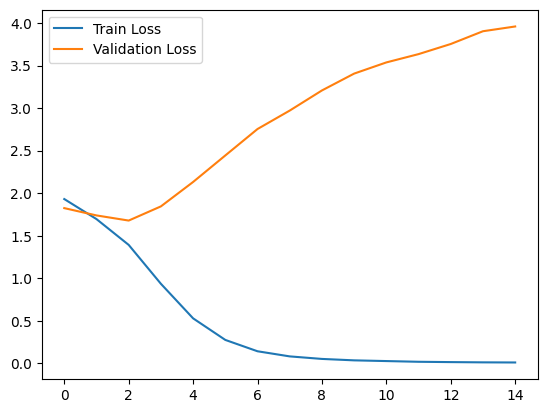

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Sequential model

In [6]:
# Build the CNN model

model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len,
              weights=[embedding_matrix], trainable=False),  # 设置 trainable=False 表示不再训练词嵌入层
    Conv1D(128, 5, activation='relu'),
    #Conv1D(64, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(train_labels)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          500100    
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 14)                910       
                                                        

In [7]:
history = model.fit(train_padded, train_labels, epochs=20, batch_size=64, validation_data=(val_padded, val_labels))

Epoch 1/20
193/193 [==============================] - 6s 25ms/step - loss: 1.9993 - accuracy: 0.3310 - val_loss: 1.7875 - val_accuracy: 0.3470
Epoch 2/20
193/193 [==============================] - 5s 27ms/step - loss: 1.7656 - accuracy: 0.3731 - val_loss: 1.7308 - val_accuracy: 0.3500
Epoch 3/20
193/193 [==============================] - 5s 24ms/step - loss: 1.6533 - accuracy: 0.3992 - val_loss: 1.6888 - val_accuracy: 0.3712
Epoch 4/20
193/193 [==============================] - 5s 24ms/step - loss: 1.5429 - accuracy: 0.4320 - val_loss: 1.6788 - val_accuracy: 0.3788
Epoch 5/20
193/193 [==============================] - 4s 23ms/step - loss: 1.4329 - accuracy: 0.4570 - val_loss: 1.6645 - val_accuracy: 0.3818
Epoch 6/20
193/193 [==============================] - 5s 24ms/step - loss: 1.3331 - accuracy: 0.5005 - val_loss: 1.6795 - val_accuracy: 0.3879
Epoch 7/20
193/193 [==============================] - 4s 23ms/step - loss: 1.1984 - accuracy: 0.5531 - val_loss: 1.7336 - val_accuracy: 0.3947

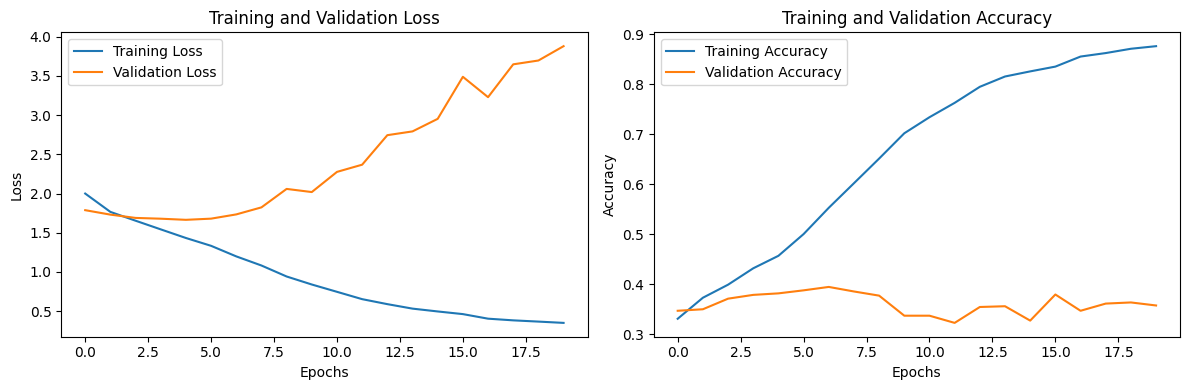

In [8]:
# 绘制训练过程中的loss和accuracy曲线
plt.figure(figsize=(12, 4))

# 绘制 Loss 曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制 Accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# 在测试集上评估模型
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print(f'Test Accuracy: {test_acc}')

42/42 [==============================] - 0s 7ms/step - loss: 3.9590 - accuracy: 0.3598
Test Accuracy: 0.3598484992980957
